In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Churn_Modelling.csv")

In [3]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [4]:
df = df.dropna()

In [5]:
X = df.drop(columns=["RowNumber","CustomerId","Surname","Exited"]) #we are removing unwanted columns from df
y = df["Exited"]

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [7]:
cat_colm = ["Geography","Gender","HasCrCard","IsActiveMember"]

In [8]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
ohe = OneHotEncoder()
X_train_cat = ohe.fit_transform(X_train[cat_colm]).toarray()
X_test_cat = ohe.transform(X_test[cat_colm]).toarray()

In [10]:
X_train.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
34,722,Spain,Female,29.0,9,0.0,2,1.0,1.0,142033.07


In [11]:
num_colm = ["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_colm])
X_test_num = scaler.transform(X_test[num_colm])

In [12]:
X_train_combined = np.hstack([X_train_num, X_train_cat])
X_test_combined  = np.hstack([X_test_num, X_test_cat])

In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_combined,y_train)

LogisticRegression()

In [14]:
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report

In [15]:
y_preds = model.predict(X_test_combined)
y_preds_proba = model.predict_proba(X_test_combined)

In [16]:
roc_auc_score(y_test,y_preds)

0.5954096462705686

In [17]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1592
           1       0.60      0.23      0.33       408

    accuracy                           0.81      2000
   macro avg       0.71      0.60      0.61      2000
weighted avg       0.78      0.81      0.78      2000



In [18]:
cm = confusion_matrix(y_test,y_preds)

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

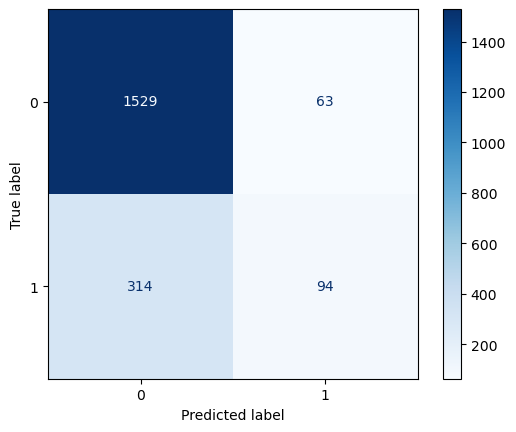

In [20]:
ConfusionMatrixDisplay(cm).plot(cmap='Blues')

In [21]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=10, min_samples_split= 2, n_estimators= 400)
rfc.fit(X_train_combined,y_train)

RandomForestClassifier(max_depth=10, n_estimators=400)

In [22]:
y_preds_rfc = rfc.predict(X_test_combined)
print("cm:\n",confusion_matrix(y_preds_rfc,y_test),
"\nclassification report:\n",classification_report(y_preds_rfc,y_test),
"\nroc_aoc_curve:\n",roc_auc_score(y_preds_rfc,y_test))

cm:
 [[1546  236]
 [  46  172]] 
classification report:
               precision    recall  f1-score   support

           0       0.97      0.87      0.92      1782
           1       0.42      0.79      0.55       218

    accuracy                           0.86      2000
   macro avg       0.70      0.83      0.73      2000
weighted avg       0.91      0.86      0.88      2000
 
roc_aoc_curve:
 0.8282776799596372


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='roc_auc', cv=3)
grid.fit(X_train_combined, y_train)

print("Best Params:", grid.best_params_)
print("Best AUC:", grid.best_score_)

Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Best AUC: 0.8559795607703498


In [24]:
import joblib
joblib.dump(rfc,"churn_model.pkl")
joblib.dump(scaler,"scaler.pkl")
joblib.dump(ohe,"ohe.pkl")

['ohe.pkl']